# Explore here

It's recommended to use this notebook for exploration purposes.

In [31]:
# storing the html in a file to avoid scrape detector due to continuous use of the page
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

#  headers to simulate a browser visit
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# URL to scrape
url = 'https://ycharts.com/companies/TSLA/revenues'

# Simulate human delay
time.sleep(random.uniform(1, 3))

# Fetching the HTML
response = requests.get(url, headers=headers)

# Check if we received a successful response
if response.status_code == 200:
    html = response.text
    print(f"Status code: {response.status_code}")
    # Save the raw HTML to a file to inspect it
    with open("raw_html.html", "w", encoding="utf-8") as file:
        file.write(html)
else:
    print(f"Error: Status code: {response.status_code}")


Status code: 200


In [42]:
from bs4 import BeautifulSoup

# Load and parse the HTML file
with open("raw_html.html", "r", encoding="utf-8") as file:
    html_content = file.read()
soup = BeautifulSoup(html_content, "html.parser")

# Find all tables in the HTML
tables = soup.find_all("table")


tables

[<table class="table">
 <thead>
 <tr>
 <th>Date</th>
 <th class="text-right">Value</th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td>June 30, 2024</td>
 <td class="text-right">
                             
                                 25.50B
                             
                         </td>
 </tr>
 <tr>
 <td>March 31, 2024</td>
 <td class="text-right">
                             
                                 21.30B
                             
                         </td>
 </tr>
 <tr>
 <td>December 31, 2023</td>
 <td class="text-right">
                             
                                 25.17B
                             
                         </td>
 </tr>
 <tr>
 <td>September 30, 2023</td>
 <td class="text-right">
                             
                                 23.35B
                             
                         </td>
 </tr>
 <tr>
 <td>June 30, 2023</td>
 <td class="text-right">
                             
                   

In [47]:
import pandas as pd


target_table = None

# Search for the table with the name "Tesla Quarterly Revenue"
for table in tables:
    if "Tesla Quarterly Revenue" in str(table):
        target_table = table
        break

# Check if the target table was found
if target_table:
    # Initialize lists to hold the data
    dates = []
    revenues = []

    # Extract table rows
    rows = target_table.find_all('tr')

    for row in rows:
        cells = row.find_all('td')
        if len(cells) >= 2:
            date = cells[0].get_text(strip=True)
            revenue = cells[1].get_text(strip=True)
            dates.append(date)
            revenues.append(revenue)

    # Create a DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Revenue': revenues
    })

    # Print the DataFrame
    print(df)
else:
    print("Table named 'Tesla Quarterly Revenue' not found.")


#comparing the raw html with the values found in the web page it seems that just the first part of the page was scraped, not the tables


Table named 'Tesla Quarterly Revenue' not found.


In [49]:
import pandas as pd

# Sample DataFrame to be able to visualize something at the end. otherwise the graphs are blank
df = pd.DataFrame({
    'Date': ['2024-Q1', '2024-Q2', '2024-Q3'],
    'Revenue': ['$1,000,000', '$2,000,000', '']
})

# Clean the DataFrame
df['Revenue'] = df['Revenue'].replace('[\$,]', '', regex=True).astype(float)
df = df.dropna()  # Drop rows with NaN values

print(df)

ValueError: could not convert string to float: ''

In [45]:
import sqlite3

# Connect to SQLite database 
conn = sqlite3.connect('tesla_revenue.db')
cursor = conn.cursor()

# Create the table
cursor.execute('''
CREATE TABLE IF NOT EXISTS quarterly_revenue (
    Date TEXT,
    Revenue REAL
)
''')

# Insert the data
df.to_sql('quarterly_revenue', conn, if_exists='replace', index=False)

# Commit and close
conn.commit()
conn.close()

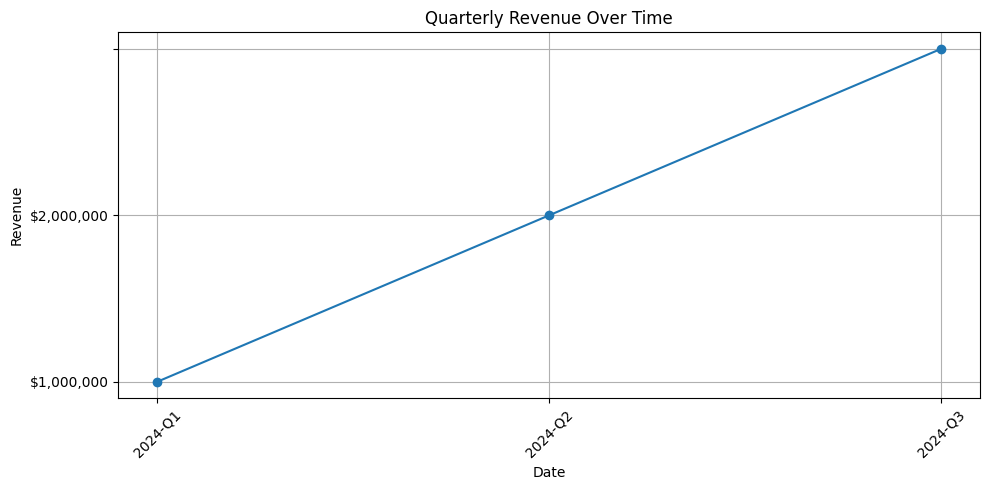

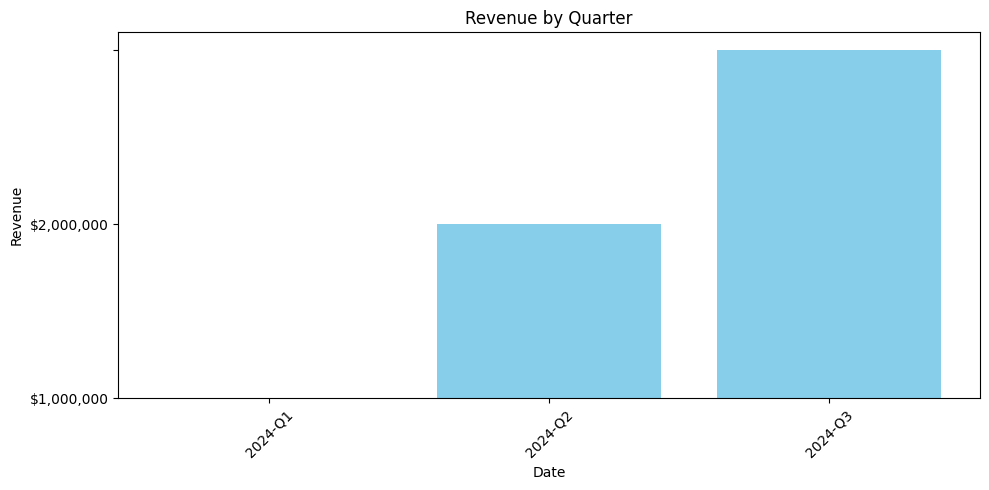

ValueError: could not convert string to float: '$1,000,000'

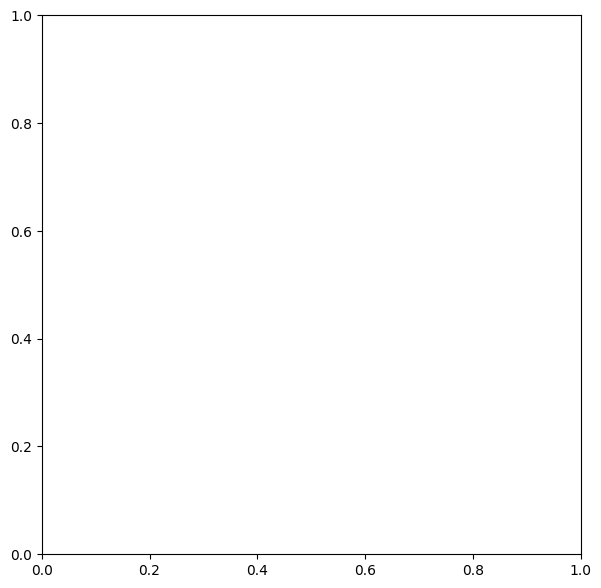

In [46]:
import matplotlib.pyplot as plt

# Reconnect to the SQLite database
conn = sqlite3.connect('tesla_revenue.db')

# Load data from SQLite into a DataFrame
df = pd.read_sql_query("SELECT * FROM quarterly_revenue", conn)

# Close the connection
conn.close()

# Line Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Revenue'], marker='o')
plt.title('Quarterly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(df['Date'], df['Revenue'], color='skyblue')
plt.title('Revenue by Quarter')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(df['Revenue'], labels=df['Date'], autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Quarter')
plt.show()
